In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm
from CR_helper import *
from Eulerian import *


In [2]:
# Example usage
n = 4  # Number of qubits
J = 1  # CR coupling strength
H_S = construct_CR_hamiltonian(n, J)


# Test DCG constructions for $R_E, R_E^\dagger, H$ gates



The first-order robust simulation is realized by implementing each operation $P_k$ through DCG constructions. 

The Euler decomposition,  $R_E = e^{-i\pi/4 Y} e^{-i\pi/4 Z}$  (and similarly $R_E^\dagger = e^{i\pi/4 Z} e^{i\pi/4 Y}$),  enables the synthesis of these gates using rotations about the $Y$ and $Z$ axes.

Appendix in the paper presents the first-order DCG implementations for arbitrary $Y$- and $Z$-axis rotations.  For any $Y$-rotation, the DCG sequence is given by

\begin{align}\label{CR_Y}
    P_{\rm DCG}^{(Y)} = \widetilde{P}(2t_p)\, 
    \widetilde{Y}_3 \widetilde{Y}_2 \widetilde{Y}_3 \widetilde{Y}_2 
    \widetilde{Y}_2 \widetilde{I}_P 
    \widetilde{Y}_3 \widetilde{I}_P 
    \widetilde{Y}_2 \widetilde{I}_P 
    \widetilde{Y}_3,
\end{align}

and for any $Z$-rotation, the corresponding DCG sequence is

\begin{align}\label{CR_Z}
    P_{\rm DCG}^{(Z)} = \widetilde{P}(2t_p)\,
    \widetilde{Z}_{12} \widetilde{Z}_{23} \widetilde{Z}_{12} \widetilde{Z}_{23}
    \widetilde{Z}_{23} \widetilde{I}_P 
    \widetilde{Z}_{12} \widetilde{I}_P 
    \widetilde{Z}_{23} \widetilde{I}_P 
    \widetilde{Z}_{12}.
\end{align}


All such DCG constructions are implemented in the `CR_helper.py` file.


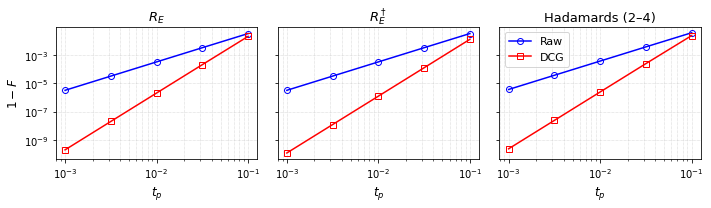

In [3]:
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

theta = np.pi / (3 * np.sqrt(3))
R_E_single = expm(-1j * theta * (X + Y + Z))

def n_qubit_RE(n):
    """Tensor product of n R_E gates."""
    R = R_E_single
    for _ in range(n - 1):
        R = np.kron(R, R_E_single)
    return R

R_E = n_qubit_RE(n=4)

# Hadamard on qubit 2 and 4
Had = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=complex)
H_4 = np.kron(I, np.kron(Had, np.kron(I, Had)))

# --- Experimental settings ---

tplist = np.logspace(-3, -1, 5)

def H_DCG(H_S, tp):
    """Composite DCG for 2–4 Hadamard operation."""
    return R_Y24_DCG(H_S, tp) @ R_Z24_DCG(H_S, tp)

def H_tp(H_S, tp):
    """Finite-width raw implementation of 2–4 Hadamard operation."""
    return U_T(Y24, H_S, tp) @ U(Z24, H_S, tp)

# --- Define experiment sets (each as dict) ---

experiments = [
    {
        "title": r"$R_E$",
        "U_targ": R_E,
        "U_raw_func": R_E_tp,
        "U_dcg_func": R_E_DCG,
    },
    {
        "title": r"$R_E^\dagger$",
        "U_targ": R_E.conj().T,
        "U_raw_func": R_E_tp_dag,
        "U_dcg_func": R_E_DCG_dag,
    },
    {
        "title": "Hadamards (2–4)",
        "U_targ": H_4,
        "U_raw_func": H_tp,
        "U_dcg_func": H_DCG,
    },
]

# --- Run all experiments and collect results ---

fig, axes = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)

for ax, exp_cfg in zip(axes, experiments):
    e_naive, e_DCG = [], []

    for tp in tplist:
        U_targ = exp_cfg["U_targ"]
        U_raw  = exp_cfg["U_raw_func"](H_S, tp)
        U_dcg  = exp_cfg["U_dcg_func"](H_S, tp)

        e_naive.append(gate_fidelity(U_raw, U_targ, 4))
        e_DCG.append(gate_fidelity(U_dcg, U_targ, 4))

    ax.plot(tplist, e_naive, 'o-', color='blue', label='Raw', mfc='none')
    ax.plot(tplist, e_DCG,  's-', color='red', label='DCG',  mfc='none')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(exp_cfg["title"], fontsize=13)
    ax.grid(True, which='both', ls=':', lw=0.5)

axes[0].set_ylabel(r"$1 - F$", fontsize=12)
for ax in axes:
    ax.set_xlabel(r"$t_p$", fontsize=12)

axes[-1].legend(fontsize=11)
plt.tight_layout()
plt.show()

# Robust Quantum Simulation



### Algorithm 1: High-Order Simulation Sequence

We now apply **Algorithm 1** to construct quantum simulation sequences 
achieving up to **fourth-order accuracy**.  For the below implementation, we **assume access to negative-time evolutions**, which will later be realized explicitly in the next section of the same notebook.

The sequences are built recursively using first-, second-, and fourth-order
Trotter formulas:

\begin{align}
\mathcal{S}_{1}(T), \quad
\mathcal{S}_{2}(T), \quad
\mathcal{S}_{4}(T),
\end{align}

Each sequence is implemented both in its **raw** (finite-width) form and its
**DCG-implementation** version for direct error comparison.

In [4]:
# TARGET: 4-qubit Heisenberg Hamiltonian
n_qubits = 4
positions = list(range(n_qubits))
H_X = construct_hamiltonian_term(X, positions)
H_Y = construct_hamiltonian_term(Y, positions)
H_Z = construct_hamiltonian_term(Z, positions)
H_targ = H_X + H_Y + H_Z

In [5]:
def Tro1(tau,tp,label):
    if label == 'DCG':
        R_E_G = R_E_DCG(H_S,tp)
        R_E_dag_G = R_E_DCG_dag(H_S,tp)
        H_G = H_DCG(H_S,tp)
    else:
        R_E_G = R_E_tp(H_S,tp)
        R_E_dag_G = R_E_tp_dag(H_S,tp)
        H_G = H_tp(H_S,tp)
        
    ftau = scipy.linalg.expm(-1j*np.matrix(H_S)*tau)
    P1 = (H_G@R_E_dag_G)
    P2 = (H_G@R_E_G@R_E_G@H_G)
    P3 = (H_G@R_E_dag_G@H_G)
    P4 = H_G
    
    return P4@ftau@P3@ftau@P2@ftau@P1

In [6]:
def Tro2(tau,tp,label):
    if label == 'DCG':
        R_E_G = R_E_DCG(H_S,tp)
        R_E_dag_G = R_E_DCG_dag(H_S,tp)
        H_G = H_DCG(H_S,tp)
    else:
        R_E_G = R_E_tp(H_S,tp)
        R_E_dag_G = R_E_tp_dag(H_S,tp)
        H_G = H_tp(H_S,tp)
        
    ftau = scipy.linalg.expm(-1j*np.matrix(H_S)*tau/2)
    P1 = (H_G@R_E_dag_G)
    P2 = (H_G@R_E_G@R_E_G@H_G)
    P3 = (H_G@R_E_dag_G@H_G)
    P4 = H_G
    
    P1_dag = R_E_G@H_G
    P2_dag = H_G@R_E_dag_G@R_E_dag_G@H_G
    P3_dag = H_G@R_E_G@H_G
    P4_dag = H_G
    
    return (P4@ftau@P3@ftau@P2@ftau@P1)@(P1_dag@ftau@P2_dag@ftau@P3_dag@ftau@P4_dag)

In [7]:
def Tro4(tau,tp,label):
    u2 = 1/(4-4**(1/3))
    U_2 = Tro2(u2*tau,tp,label)
    U_2m = Tro2((1-4*u2)*tau,tp,label)
    return U_2@U_2@U_2m@U_2@U_2

In [8]:
#Run simulation

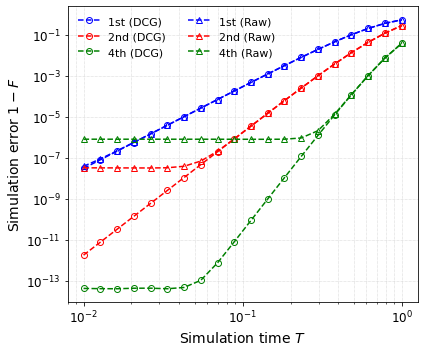

In [9]:
tp = 1e-5
taulist = np.logspace(-2, 0, 20)

e_T1, e_T2, e_T4 = [], [], []
e_T1_tp, e_T2_tp, e_T4_tp = [], [], []

for tau in taulist:
    U_targ = scipy.linalg.expm(-1j * H_targ * tau)

    # --- DCG versions ---
    e_T1.append(gate_fidelity(Tro1(tau, tp, "DCG"), U_targ, 4))
    e_T2.append(gate_fidelity(Tro2(tau, tp, "DCG"), U_targ, 4))
    e_T4.append(gate_fidelity(Tro4(tau, tp, "DCG"), U_targ, 4))

    # --- Raw versions ---
    e_T1_tp.append(gate_fidelity(Tro1(tau, tp, "Raw"), U_targ, 4))
    e_T2_tp.append(gate_fidelity(Tro2(tau, tp, "Raw"), U_targ, 4))
    e_T4_tp.append(gate_fidelity(Tro4(tau, tp, "Raw"), U_targ, 4))

# ================================================================
# --- Plot ---
# ================================================================
fig, ax = plt.subplots(figsize=(6, 5))
ms = 6

# DCG curves
ax.plot(taulist, e_T1, 'o--', color='blue',  ms=ms, mfc='none', label='1st (DCG)')
ax.plot(taulist, e_T2, 'o--', color='red',   ms=ms, mfc='none', label='2nd (DCG)')
ax.plot(taulist, e_T4, 'o--', color='green', ms=ms, mfc='none', label='4th (DCG)')

# Raw curves
ax.plot(taulist, e_T1_tp, '^--', color='blue',  ms=ms, mfc='none', label='1st (Raw)')
ax.plot(taulist, e_T2_tp, '^--', color='red',   ms=ms, mfc='none', label='2nd (Raw)')
ax.plot(taulist, e_T4_tp, '^--', color='green', ms=ms, mfc='none', label='4th (Raw)')

# Axes and formatting
ax.set_xlabel(r'Simulation time $T$', fontsize=14)
ax.set_ylabel(r'Simulation error $1 - F$', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', ls=':', lw=0.5)
ax.legend(fontsize=11, ncol=2, loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


# Negative time



In [10]:
# --- Eulerian and Naive cycles for 4-qubit system ---

# Example Eulerian (first-order) cycle (4-qubit, Y-rotations on different qubits)
Euler1 = [
    ('I', 'I', 'Y', 'I'),
    ('I', 'Y', 'I', 'I'),
    ('I', 'I', 'Y', 'I'),
    ('I', 'Y', 'I', 'I'),
    ('I', 'Y', 'I', 'I'),
    ('I', 'I', 'Y', 'I'),
    ('I', 'Y', 'I', 'I'),
    ('I', 'I', 'Y', 'I'),
]
Euler1_cycle = [create_sum_matrix(pauli) for pauli in Euler1]

# Generate full Eulerian cycle from Cayley graph (for concatenation)
cycle = find_eulerian_cycle(generate_cayley_graph(4))
Euler_cycle = compute_transition_paulis(cycle)
Euler_cycle_mat = [create_sum_matrix(pauli) for pauli in Euler_cycle]

# Construct naive pulse cycle (non-Eulerian reference)
pauli_elements = generate_pauli_group(4)
pulse_elements = compute_transition_paulis(pauli_elements)
pulse_elements.append(pauli_elements[-1])  # close cycle
Naive_cycle_mat_4 = [create_sum_matrix(pauli) for pauli in pulse_elements]


In [11]:
# ================================================================
# --- Refocusing and Eulerian Symmetrized DD constructions ---
# ================================================================

# ------------------------------------------------
# Level-1 EDD and its time-symmetrized version
# ------------------------------------------------
def EDD(tau, tp):
    DD = np.eye(2**4)
    ftau = scipy.linalg.expm(-1j*H_S*tau)
    for M in Euler1_cycle:
        DD = (U(M,H_S,tp)@ftau)@DD
    return DD


def EDD_symm(tau, tp):
    DD = np.eye(2**4)
    ftau = scipy.linalg.expm(-1j*H_S*tau)
    for M in Euler1_cycle:
        DD = (U(M,H_S,tp)@ftau)@DD
    for i in range(len(Euler1_cycle)):
        M = Euler1_cycle[len(Euler1_cycle)-1-i]
        DD = (ftau@U_rev(M,H_S,tp))@DD
    return DD

# ------------------------------------------------
# Eulerian Symmetrized Concatenated DD (ESCDD) for k = 2
# ------------------------------------------------
def refocus_4(tau, tp):
    assert tau > 0, "tau must be positive"
    ESCDD1_symm = np.eye(2**4)
    EDD_block = EDD_symm(tau, tp)
    for M in Euler_cycle_mat:
        ESCDD1_symm = (U(M, H_S, tp) @ EDD_block) @ ESCDD1_symm
    for M in reversed(Euler_cycle_mat):
        ESCDD1_symm = (EDD_block @ U_rev(M, H_S, tp)) @ ESCDD1_symm
    return ESCDD1_symm @ scipy.linalg.expm(1j * H_S * tau)



In [15]:
#If needed (e.g., for very small t_p):

def project_to_unitary(A):
    """project to the closest unitary A (polar decomposition)."""
    try:
        U, _ = scipy.linalg.polar(A)
    except Exception:
        # fallback to SVD
        U_svd, _, Vh = np.linalg.svd(A)
        U = U_svd @ Vh
    return U


# ------------------------------------------------
# Eulerian Symmetrized CDD (ESCDD) for k = 2
# with periodic re-unitarization (fixed parameters)
# ------------------------------------------------
def refocus_4_project(tau, tp):
    """
    tau, tp: durations
    Project to the unitary via polar decomposition periodically.
    This is used to handle the numerical instability due to numerous matrix multiplications.
    """
    assert tau > 0, "tau must be positive"

    n = 2**4
    ESCDD1_symm = np.eye(n, dtype=complex)
    EDD_block = EDD_symm(tau, tp)

    reunitarize_every = 256   # frequency of projection
    mults = 0

    # Forward pass
    for M in Euler_cycle_mat:
        ESCDD1_symm = (U(M, H_S, tp) @ EDD_block) @ ESCDD1_symm
        mults += 2
        if mults % reunitarize_every == 0:
            ESCDD1_symm = project_to_unitary(ESCDD1_symm)

    # Reverse pass
    for M in reversed(Euler_cycle_mat):
        ESCDD1_symm = (EDD_block @ U_rev(M, H_S, tp)) @ ESCDD1_symm
        mults += 2
        if mults % reunitarize_every == 0:
            ESCDD1_symm = project_to_unitary(ESCDD1_symm)

    ESCDD1_symm = ESCDD1_symm @ scipy.linalg.expm(1j * H_S * tau)
    ESCDD1_symm = project_to_unitary(ESCDD1_symm)
    return ESCDD1_symm


In [13]:
# ================================================================
# --- Higher-order Trotter integration with ESCDD ---
# ================================================================

def Tro2_ESCDD(tau, tp, label):
    """Second-order ESCDD-based Trotter sequence."""
    if label == 'DCG':
        R_E_G = R_E_DCG(H_S, tp)
        R_E_dag_G = R_E_DCG_dag(H_S, tp)
        H_G = H_DCG(H_S, tp)
    else:
        R_E_G = R_E_tp(H_S, tp)
        R_E_dag_G = R_E_tp_dag(H_S, tp)
        H_G = H_tp(H_S, tp)

    ftau = refocus_4_project(-tau / 2, tp)

    P1 = H_G @ R_E_dag_G
    P2 = H_G @ R_E_G @ R_E_G @ H_G
    P3 = H_G @ R_E_dag_G @ H_G
    P4 = H_G

    P1_dag = R_E_G @ H_G
    P2_dag = H_G @ R_E_dag_G @ R_E_dag_G @ H_G
    P3_dag = H_G @ R_E_G @ H_G
    P4_dag = H_G

    return (P4 @ ftau @ P3 @ ftau @ P2 @ ftau @ P1) @ (
        P1_dag @ ftau @ P2_dag @ ftau @ P3_dag @ ftau @ P4_dag
    )


def Tro4_ESCDD(tau, tp, label):
    """Fourth-order ESCDD-based Trotter sequence."""
    u2 = 1 / (4 - 4 ** (1 / 3))
    U_2 = Tro2(u2 * tau, tp, label)
    U_2m = Tro2_ESCDD((1 - 4 * u2) * tau, tp, label)
    return U_2 @ U_2 @ U_2m @ U_2 @ U_2

In [16]:
# --- Parameter setup ---
tp_list = [1e-3, 1e-4, 1e-5]
Tlist = np.logspace(-2, 0, 20)

# --- Containers for results ---
results = {}

for tp in tp_list:
    print(f"\n=== Running simulation for tp = {tp:.1e} ===")
    
    e_T1, e_T2, e_T4 = [], [], []
    e_T1_tp, e_T2_tp, e_T4_tp = [], [], []
    e_T4_ESCDD = []

    for T in Tlist:
        print(f"  Simulation time T : {T:.3e}")
        U_targ = scipy.linalg.expm(-1j * H_targ * T)

        # --- DCG versions ---
        e_T1.append(gate_fidelity(Tro1(T, tp, "DCG"), U_targ, 4))
        e_T2.append(gate_fidelity(Tro2(T, tp, "DCG"), U_targ, 4))
        e_T4.append(gate_fidelity(Tro4(T, tp, "DCG"), U_targ, 4))
        e_T4_ESCDD.append(gate_fidelity(Tro4_ESCDD(T, tp, "DCG"), U_targ, 4))

        # --- Raw versions ---
        e_T1_tp.append(gate_fidelity(Tro1(T, tp, "Raw"), U_targ, 4))
        e_T2_tp.append(gate_fidelity(Tro2(T, tp, "Raw"), U_targ, 4))
        e_T4_tp.append(gate_fidelity(Tro4(T, tp, "Raw"), U_targ, 4))

    results[tp] = {
        'DCG': [e_T1, e_T2, e_T4, e_T4_ESCDD],
        'Raw': [e_T1_tp, e_T2_tp, e_T4_tp],
    }


=== Running simulation for tp = 1.0e-03 ===
  Simulation time T : 1.000e-02
  Simulation time T : 1.274e-02
  Simulation time T : 1.624e-02
  Simulation time T : 2.069e-02
  Simulation time T : 2.637e-02
  Simulation time T : 3.360e-02
  Simulation time T : 4.281e-02
  Simulation time T : 5.456e-02
  Simulation time T : 6.952e-02
  Simulation time T : 8.859e-02
  Simulation time T : 1.129e-01
  Simulation time T : 1.438e-01
  Simulation time T : 1.833e-01
  Simulation time T : 2.336e-01
  Simulation time T : 2.976e-01
  Simulation time T : 3.793e-01
  Simulation time T : 4.833e-01
  Simulation time T : 6.158e-01
  Simulation time T : 7.848e-01
  Simulation time T : 1.000e+00

=== Running simulation for tp = 1.0e-04 ===
  Simulation time T : 1.000e-02
  Simulation time T : 1.274e-02
  Simulation time T : 1.624e-02
  Simulation time T : 2.069e-02
  Simulation time T : 2.637e-02
  Simulation time T : 3.360e-02
  Simulation time T : 4.281e-02
  Simulation time T : 5.456e-02
  Simulation t

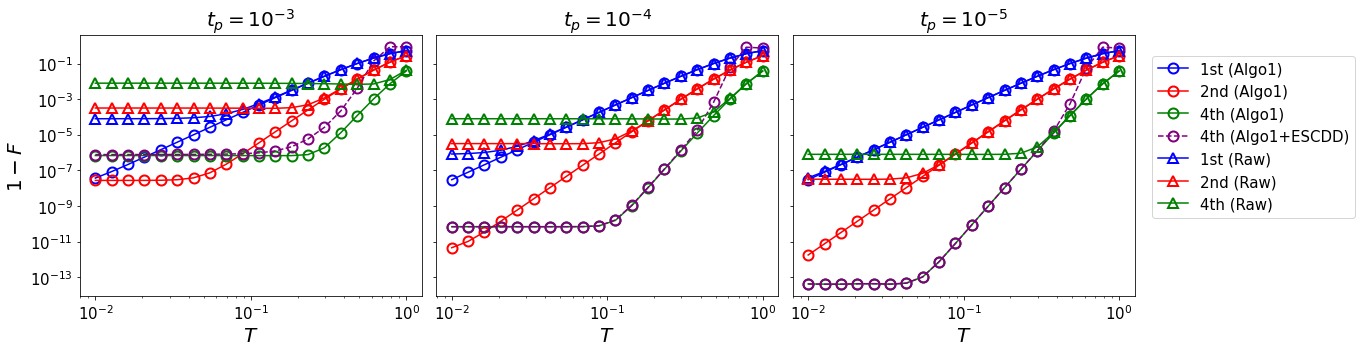

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5), sharey=True)
ms = 10
mw = 2

for i, tp in enumerate(tp_list):
    ax = axs[i]
    e_T1, e_T2, e_T4, e_T4_ESCDD = results[tp]['DCG']
    e_T1_tp, e_T2_tp, e_T4_tp = results[tp]['Raw']

    # --- DCG sequences ---
    ax.plot(Tlist, e_T1, 'o-', color='blue',  ms=ms, markerfacecolor="None", markeredgewidth=mw, label='1st (Algo1)')
    ax.plot(Tlist, e_T2, 'o-', color='red',   ms=ms, markerfacecolor="None", markeredgewidth=mw, label='2nd (Algo1)')
    ax.plot(Tlist, e_T4, 'o-', color='green', ms=ms, markerfacecolor="None", markeredgewidth=mw, label='4th (Algo1)')
    ax.plot(Tlist, e_T4_ESCDD, 'o--', color='purple', ms=ms, markerfacecolor="None", \
            markeredgewidth=mw, label='4th (Algo1+ESCDD)')

    # --- Raw sequences ---
    ax.plot(Tlist, e_T1_tp, '^-', color='blue',  ms=ms, markerfacecolor="None", markeredgewidth=mw, label='1st (Raw)')
    ax.plot(Tlist, e_T2_tp, '^-', color='red',   ms=ms, markerfacecolor="None", markeredgewidth=mw, label='2nd (Raw)')
    ax.plot(Tlist, e_T4_tp, '^-', color='green', ms=ms, markerfacecolor="None", markeredgewidth=mw, label='4th (Raw)')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$T$', fontsize=20)
    if i == 0:
        ax.set_ylabel(r'$1 - F$', fontsize=20)
    ax.set_title(fr'$t_p = 10^{{{int(np.log10(tp))}}}$', fontsize=20)
    #ax.grid(True, which='both', ls=':', lw=0.5)
    ax.tick_params(axis='both', which='major', labelsize=15)

axs[2].legend(ncol=1, loc=(1.05, 0.3), fontsize=15)
plt.tight_layout()
#plt.savefig("CR_Numerics", dpi = 200)
plt.show()

# Multi-product formula

We now perform the pulse sequences for multiproduct formula (MPF):

\begin{align}\label{num2_MPF}
M^{(2)}(t) = \frac{4}{3}\mathcal{S}^2_2(t/2) - \frac{1}{3}\mathcal{S}_2(t),
\end{align}
which achieves an $\mathcal{O}(t^5)$ error.  

We measure the trace-distance error:

\begin{align}\label{cr_MPF_error}
\Big\| e^{-iH_{\text{targ}}T}\rho e^{iH_{\text{targ}}T}
- \sum_{j=1}^2 b_j\, \widetilde{\mathcal{S}}^{k_j}_2(T/k_j)\rho 
(\widetilde{\mathcal{S}}^{k_j}_2(T/k_j))^\dagger \Big\|_1,
\end{align}

where $\rho = (|{0}\rangle\langle{0}|)^{\otimes 4}$, $t_p = 10^{-5}$, and $(b_1,b_2,k_1,k_2) = (\tfrac{4}{3}, -\tfrac{1}{3}, 1, 2)$.  

Each $\widetilde{\mathcal{S}}^{k_j}_2(T/k_j)$ is constructed by scaling all $\tau_k$ by $1/k_j$ (i.e. free-evolution period is uniformly rescaled by $1/k_j$), repeating the entire sequence $k_j$ times, and replacing every $P_k, P_k^\dagger$ with their corresponding DCG implementations.


In [18]:
# ================================================================
#  Multi-Product Formula (MPF) simulation 
# ================================================================

def rho_MPF(rho0, klist, clist, tau, tp):
    rho_out = np.zeros_like(rho0, dtype=complex)
    for k_j, c_j in zip(klist, clist):
        S2kj = np.linalg.matrix_power(Tro2(tau / k_j, tp, "DCG"), k_j)
        rho_out += c_j * (S2kj @ rho0 @ S2kj.conj().T)
    return rho_out

In [19]:
#  Simulation setup

klist = [1, 2]          # MPF orders
clist = [-1/3, 4/3]     # corresponding coefficients (4th-order Childs-type)
tp = 1e-5               # finite pulse width

rho0 = np.array([[1, 0], [0, 0]], dtype=complex)
rho_init = np.kron(rho0, np.kron(rho0, np.kron(rho0, rho0)))   # |0000⟩⟨0000|

# Containers
e_T1_MPF, e_T2_MPF, e_T4_MPF = [], [], []
Tlist = np.logspace(-2, 0, 20)

# ================================================================
#  Loop over total evolution time τ
# ================================================================

for T in Tlist:
    U_id = scipy.linalg.expm(-1j * H_targ * T)
    rho_id = U_id @ rho_init @ U_id.conj().T

    # First- and second-order sequences
    rho1 = Tro1(T, tp, "DCG") @ rho_init @ Tro1(T, tp, "DCG").conj().T
    rho2 = Tro2(T, tp, "DCG") @ rho_init @ Tro2(T, tp, "DCG").conj().T

    # Multi-product combination (4th-order)
    rho4 = rho_MPF(rho_init, klist, clist, T, tp)

    # Trace-distance errors
    e_T1_MPF.append(trace_distance(rho_id, rho1, 4))
    e_T2_MPF.append(trace_distance(rho_id, rho2, 4))
    e_T4_MPF.append(trace_distance(rho_id, rho4, 4))

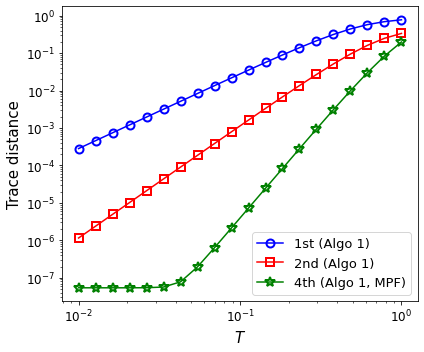

In [21]:
#  Figure: Multi-Product Formula (Algorithm 1) simulation accuracy

fig, ax = plt.subplots(figsize=(6, 5))
ms=8
ax.plot(Tlist, e_T1_MPF, 'o-', color='blue', markersize=ms,
        markeredgecolor='blue', markerfacecolor='none', markeredgewidth=mw,
        label=r'1st (Algo 1)')
ax.plot(Tlist, e_T2_MPF, 's-', color='red', markersize=ms,
        markeredgecolor='red', markerfacecolor='none', markeredgewidth=mw,
        label=r'2nd (Algo 1)')
ax.plot(Tlist, e_T4_MPF, '*-', color='green', markersize=ms+2,
        markeredgecolor='green', markerfacecolor='none', markeredgewidth=mw,
        label=r'4th (Algo 1, MPF)')

# --- Axes settings ---
ax.set_xlabel(r'$T$', fontsize=15)
ax.set_ylabel(r'Trace distance', fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.legend(fontsize=13, loc='lower right')
#ax.grid(alpha=0.25, which='both', linestyle='--', linewidth=0.7)

fig.tight_layout()
#plt.savefig("CR_MPF", dpi = 200)
plt.show()